## **Homework 3**
**Instructions**
* This homework focuses on understanding and applying DETR for object detection and attention visualization. It consists of **three questions** designed to assess both theoretical understanding and practical application.

* Please organize your answers and results for the questions below and submit this jupyter notebook as **a .pdf file**.

* **Deadline: 11/14 (Thur) 23:59**

**Reference**
* End-to-End Object Detection with Transformers (DETR): https://github.com/facebookresearch/detr

### **Q1.  Understanding DETR model**

* Fill-in-the-blank exercise to test your understanding of critical parts of the DETR model workflow.



In [3]:
from torch import nn
import torch
from torchvision.models import resnet50

class DETR(nn.Module):
    def __init__(self, num_classes, hidden_dim=256, nheads=8,
                 num_encoder_layers=6, num_decoder_layers=6, num_queries=100):
        super().__init__()

        # create ResNet-50 backbone
        self.backbone = resnet50()
        del self.backbone.fc

        # create conversion layer
        self.conv = nn.Conv2d(2048, hidden_dim, 1)

        # create a default PyTorch transformer
        self.transformer = nn.Transformer(
            hidden_dim, nheads, num_encoder_layers, num_decoder_layers)

        # prediction heads, one extra class for predicting non-empty slots
        # note that in baseline DETR linear_bbox layer is 3-layer MLP
        self.linear_class = nn.Linear(hidden_dim, num_classes + 1)
        self.linear_bbox = nn.Linear(hidden_dim, 4)

        # output positional encodings (object queries)
        self.query_pos = nn.Parameter(torch.rand(num_queries, hidden_dim))

        # spatial positional encodings
        # note that in baseline DETR we use sine positional encodings
        self.row_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))
        self.col_embed = nn.Parameter(torch.rand(50, hidden_dim // 2))

    def forward(self, inputs):
        # propagate inputs through ResNet-50 up to avg-pool layer
        x = self.backbone.conv1(inputs)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        # convert from 2048 to 256 feature planes for the transformer
        h = self.conv(x)

        # construct positional encodings
        H, W = h.shape[-2:]
        pos = torch.cat([
            self.col_embed[:W].unsqueeze(0).repeat(H, 1, 1),
            self.row_embed[:H].unsqueeze(1).repeat(1, W, 1),
        ], dim=-1).flatten(0, 1).unsqueeze(1)

        # propagate through the transformer
        h = self.transformer(pos + 0.1 * h.flatten(2).permute(2, 0, 1),
                             self.query_pos.unsqueeze(1)).transpose(0, 1)

        # finally project transformer outputs to class labels and bounding boxes
        pred_logits = self.linear_class(h)
        pred_boxes = self.linear_bbox(h).sigmoid()  # boxes should be normalized between 0 and 1

        return {'pred_logits': pred_logits,
                'pred_boxes': pred_boxes}


#### Takeaway messages

- DETR 모델은 Transformer 기반 Object Detection 모델로, Encoder-Decoder 구조를 사용한다.
- Encoder는 이미지의 전역적 정보를 학습하고, Decoder는 객체에 집중하여 세부 정보를 추출한다.
- 이 과정에서 Self-Attention과 Cross-Attention 메커니즘을 통해 각각 전반적인 장면 이해와 특정 객체 추출을 수행한다.

### **Q2. Custom Image Detection and Attention Visualization**

In this task, you will upload an **image of your choice** (different from the provided sample) and follow the steps below:

* Object Detection using DETR
 * Use the DETR model to detect objects in your uploaded image.

* Attention Visualization in Encoder
 * Visualize the regions of the image where the encoder focuses the most.

* Decoder Query Attention in Decoder
 * Visualize how the decoder’s query attends to specific areas corresponding to the detected objects.

In [5]:
import math

from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import ipywidgets as widgets
from IPython.display import display, clear_output

import torch
from torch import nn


from torchvision.models import resnet50
import torchvision.transforms as T
torch.set_grad_enabled(False);

# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()



In [6]:
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

# Load pretrained DETR model and processor from Hugging Face
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

def detect_objects(image):
    # Prepare image for DETR
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]

    # Run model on the processed input
    outputs = model(pixel_values=pixel_values)

    # Get class probabilities and bounding boxes
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9  # Keep high-confidence detections

    # Rescale boxes to image size
    bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep], image.size)
    return probas[keep], bboxes_scaled


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
def visualize_encoder_attention(image, model):
    # Prepare image for DETR
    inputs = processor(images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"]
    pixel_mask = inputs["pixel_mask"]

    # Run model to get outputs including attentions
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)
        attentions = outputs.encoder_attentions  # List of attention maps for each encoder layer

    # Visualize attention for each encoder layer
    for layer_idx, attention in enumerate(attentions):
        fig, ax = plt.subplots()
        ax.imshow(image)
        
        # Take mean attention over heads for visualization
        attention_map = attention[0].mean(0).cpu().numpy()
        ax.imshow(attention_map, cmap="jet", alpha=0.6)
        plt.title(f'Encoder Layer {layer_idx + 1} Attention')
        plt.axis("off")
        plt.show()

In [8]:
def visualize_decoder_attention(image, model):
    # Prepare input and run up to decoder layers
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model.model.decoder(**inputs).last_hidden_state

    # Plot attention for each detected query
    for query_idx in range(5):  # Visualize top 5 queries
        attention = model.model.decoder.layer[query_idx].cross_attn.get_attention_map()
        
        # Plot decoder query attention maps
        fig, ax = plt.subplots()
        ax.imshow(image)
        attention_map = attention[0, query_idx, :, :].cpu().numpy()
        ax.imshow(attention_map, cmap="jet", alpha=0.6)
        plt.title(f'Decoder Query {query_idx+1} Attention')
        plt.axis("off")
        plt.show()


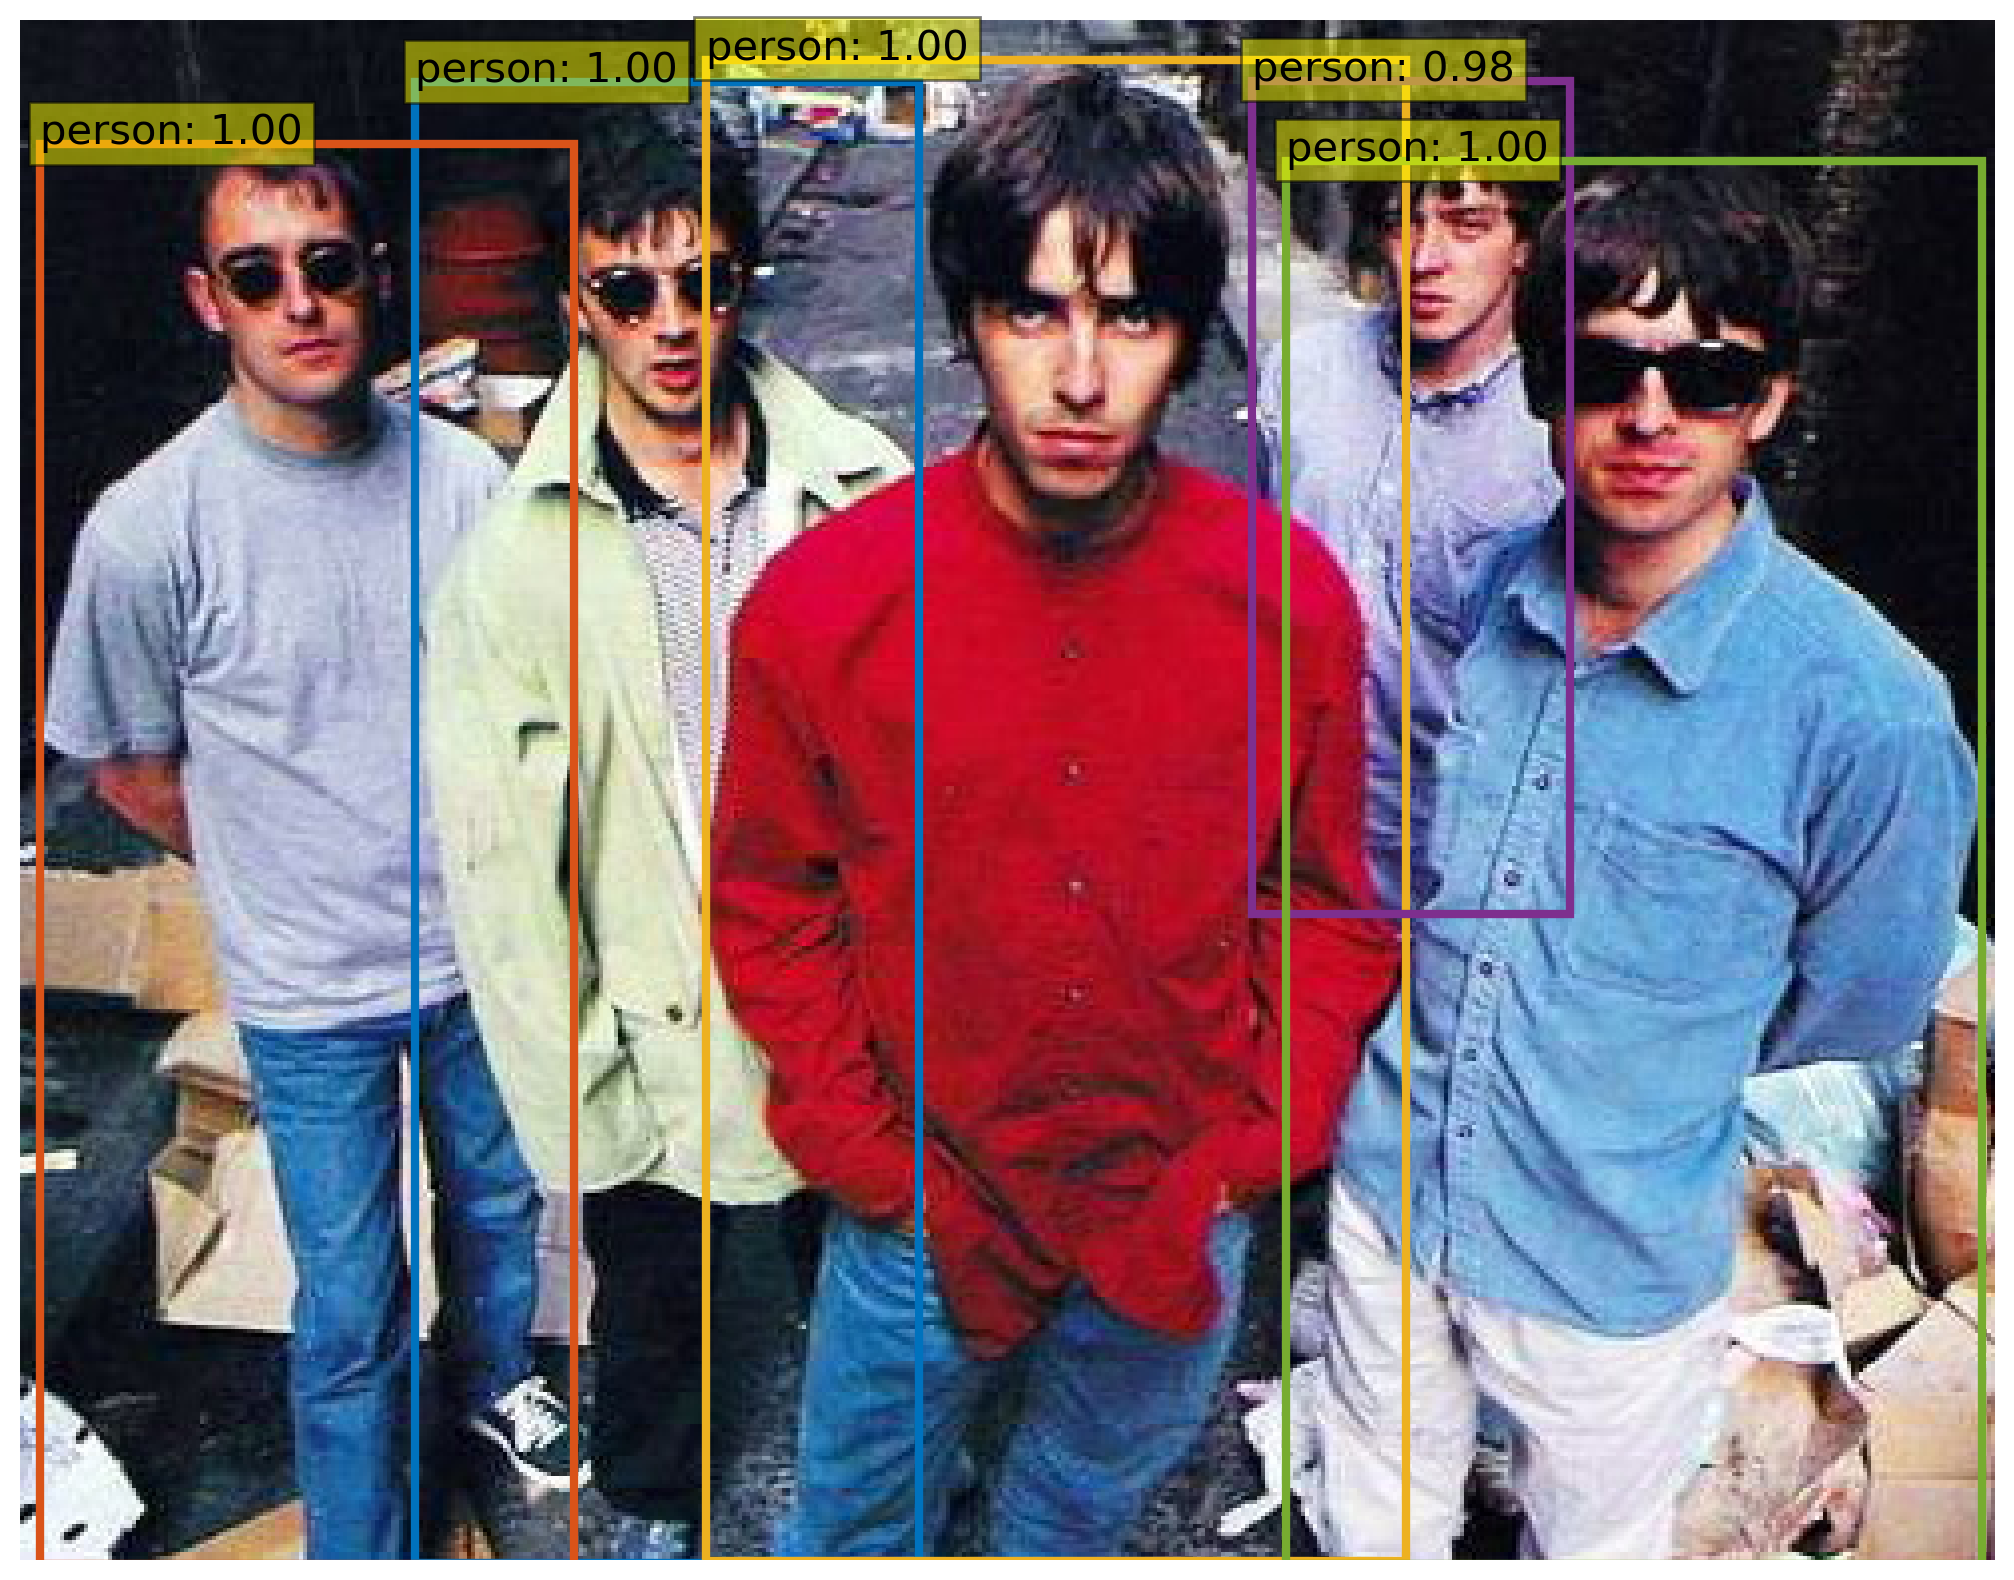

TypeError: 'NoneType' object is not iterable

In [9]:
# Load and process custom image
image_path = "C:\\Users\\Jeongeun Park\\Downloads\\oasis.jpg"

image = Image.open(image_path)

# Step 1: Run DETR object detection
probas, boxes = detect_objects(image)
plot_results(image, probas, boxes)

# Step 2: Visualize encoder attention
visualize_encoder_attention(image, model)

# Step 3: Visualize decoder query attention
visualize_decoder_attention(image, model)



In this section, we show-case how to load a model from hub, run it on a custom image, and print the result.
Here we load the simplest model (DETR-R50) for fast inference. You can swap it with any other model from the model zoo.

Using cache found in C:\Users\Jeongeun Park/.cache\torch\hub\facebookresearch_detr_main
C:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


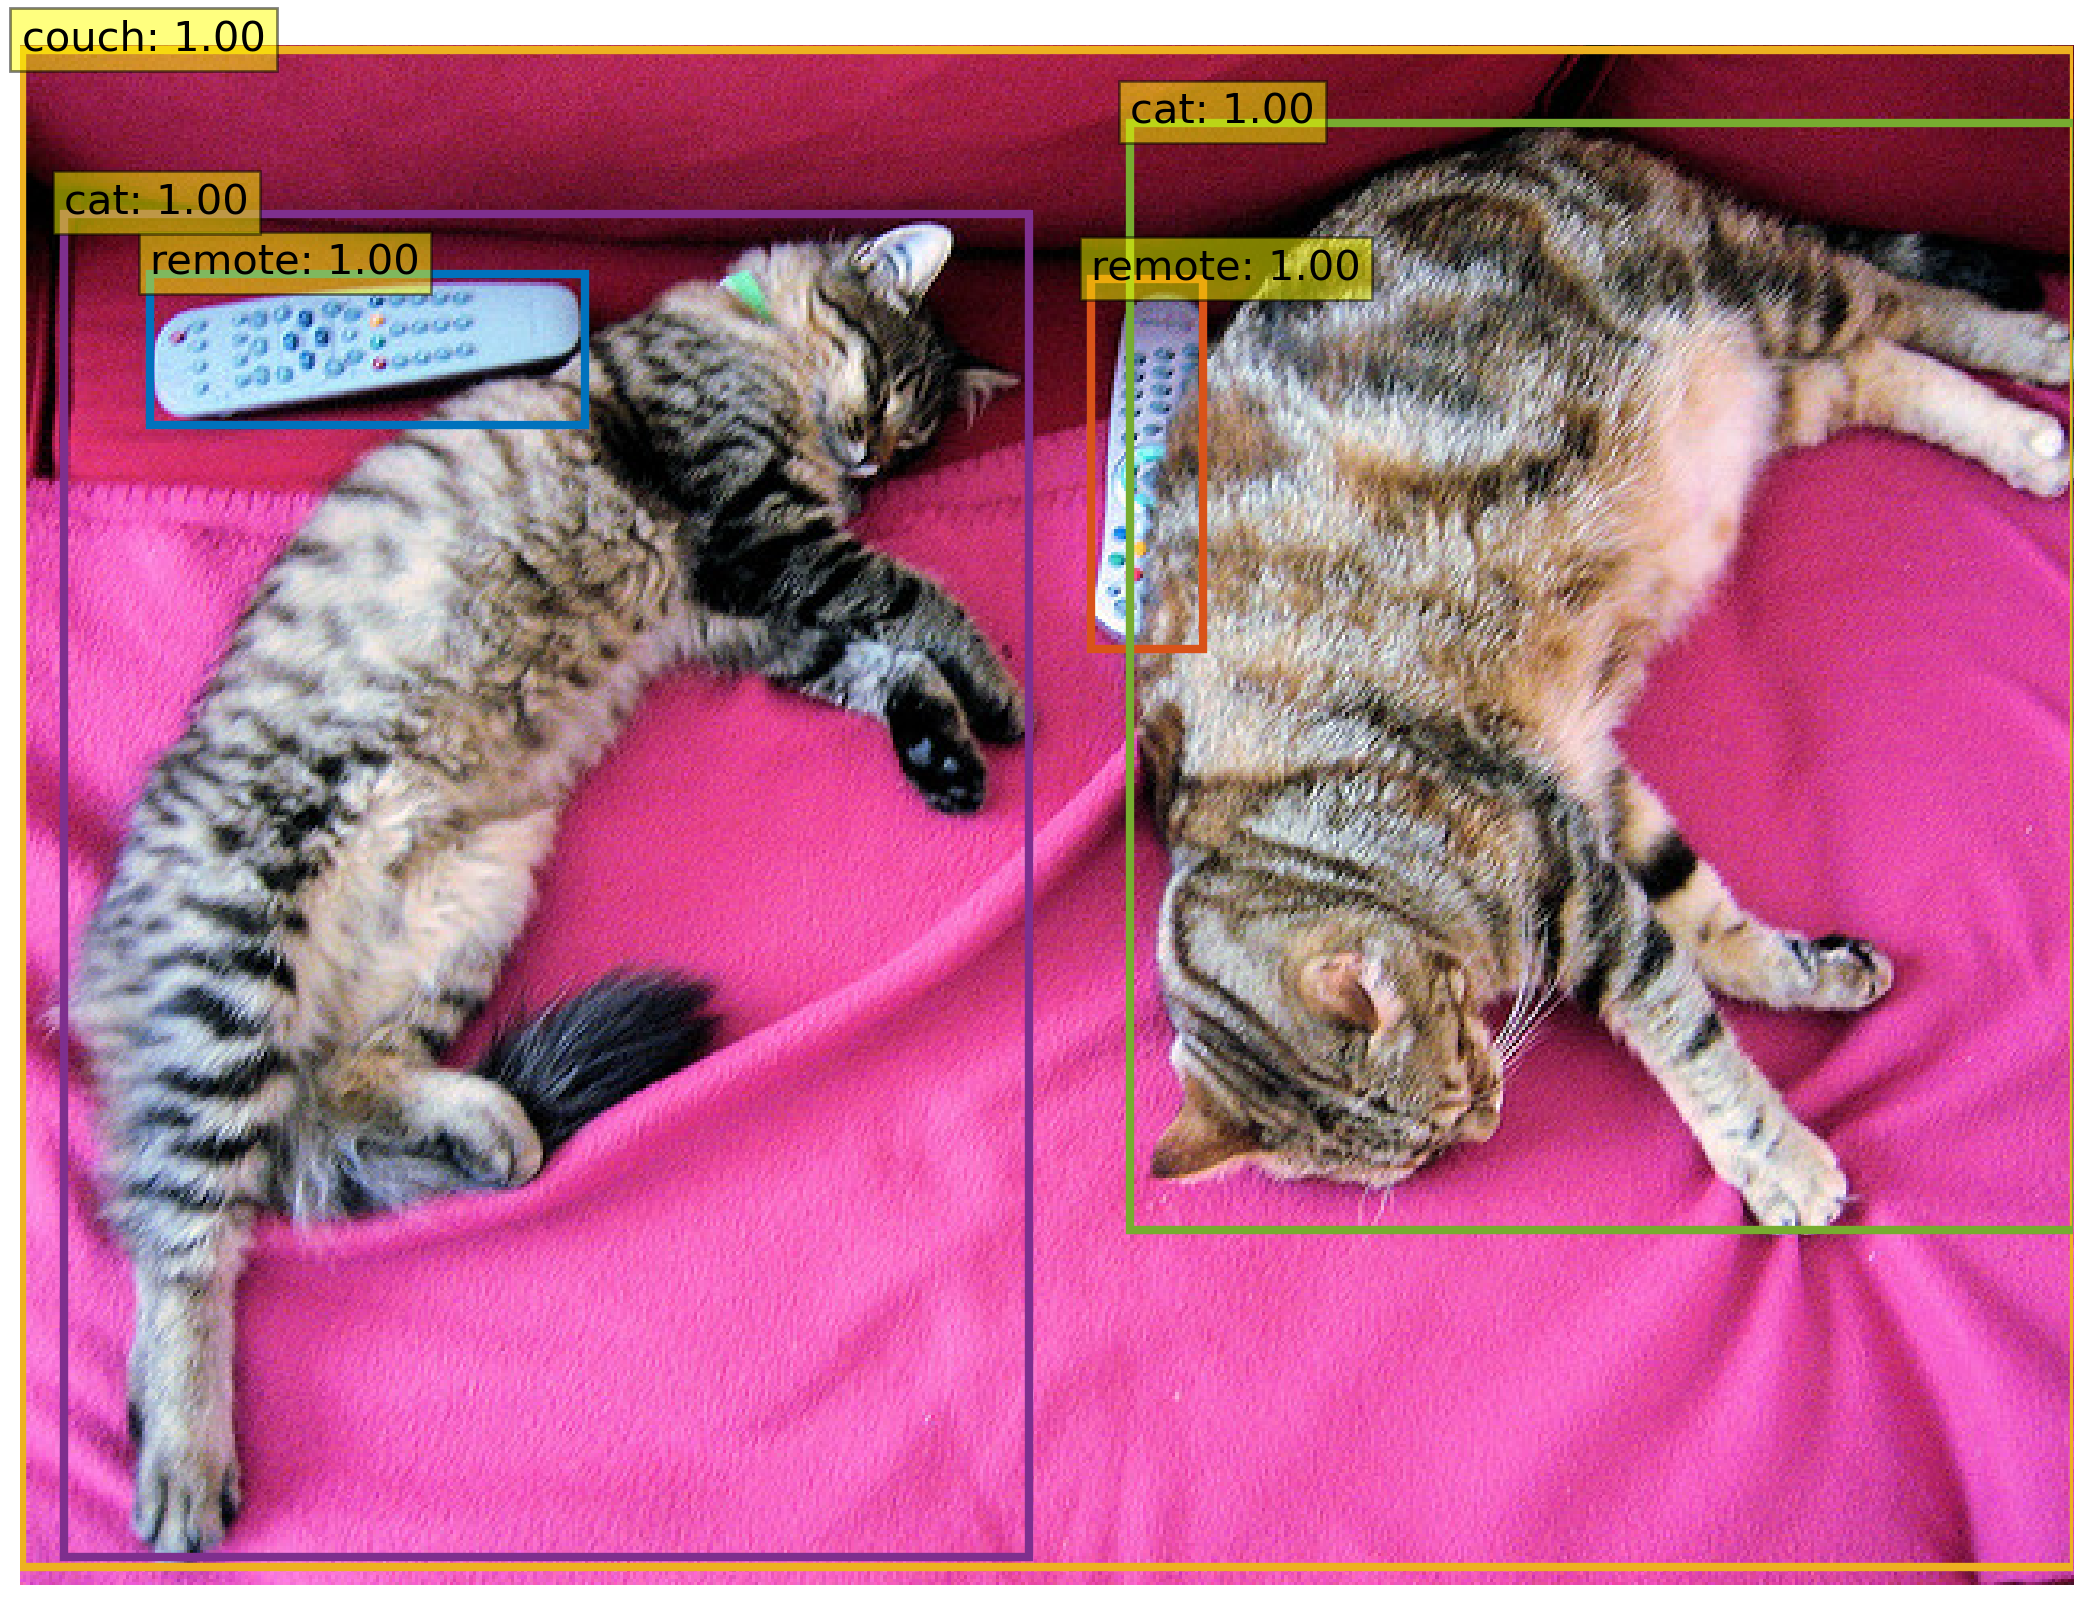

In [13]:
model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
model.eval();

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw) # put your own image

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)


Here we visualize attention weights of the last decoder layer. This corresponds to visualizing, for each detected objects, which part of the image the model was looking at to predict this specific bounding box and class.

In [14]:
# use lists to store the outputs via up-values
conv_features, enc_attn_weights, dec_attn_weights = [], [], []

hooks = [
    model.backbone[-2].register_forward_hook(
        lambda self, input, output: conv_features.append(output)
    ),
    model.transformer.encoder.layers[-1].self_attn.register_forward_hook(
        lambda self, input, output: enc_attn_weights.append(output[1])
    ),
    model.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(
        lambda self, input, output: dec_attn_weights.append(output[1])
    ),
]

# propagate through the model
outputs = model(img) # put your own image

for hook in hooks:
    hook.remove()

# don't need the list anymore
conv_features = conv_features[0]
enc_attn_weights = enc_attn_weights[0]
dec_attn_weights = dec_attn_weights[0]

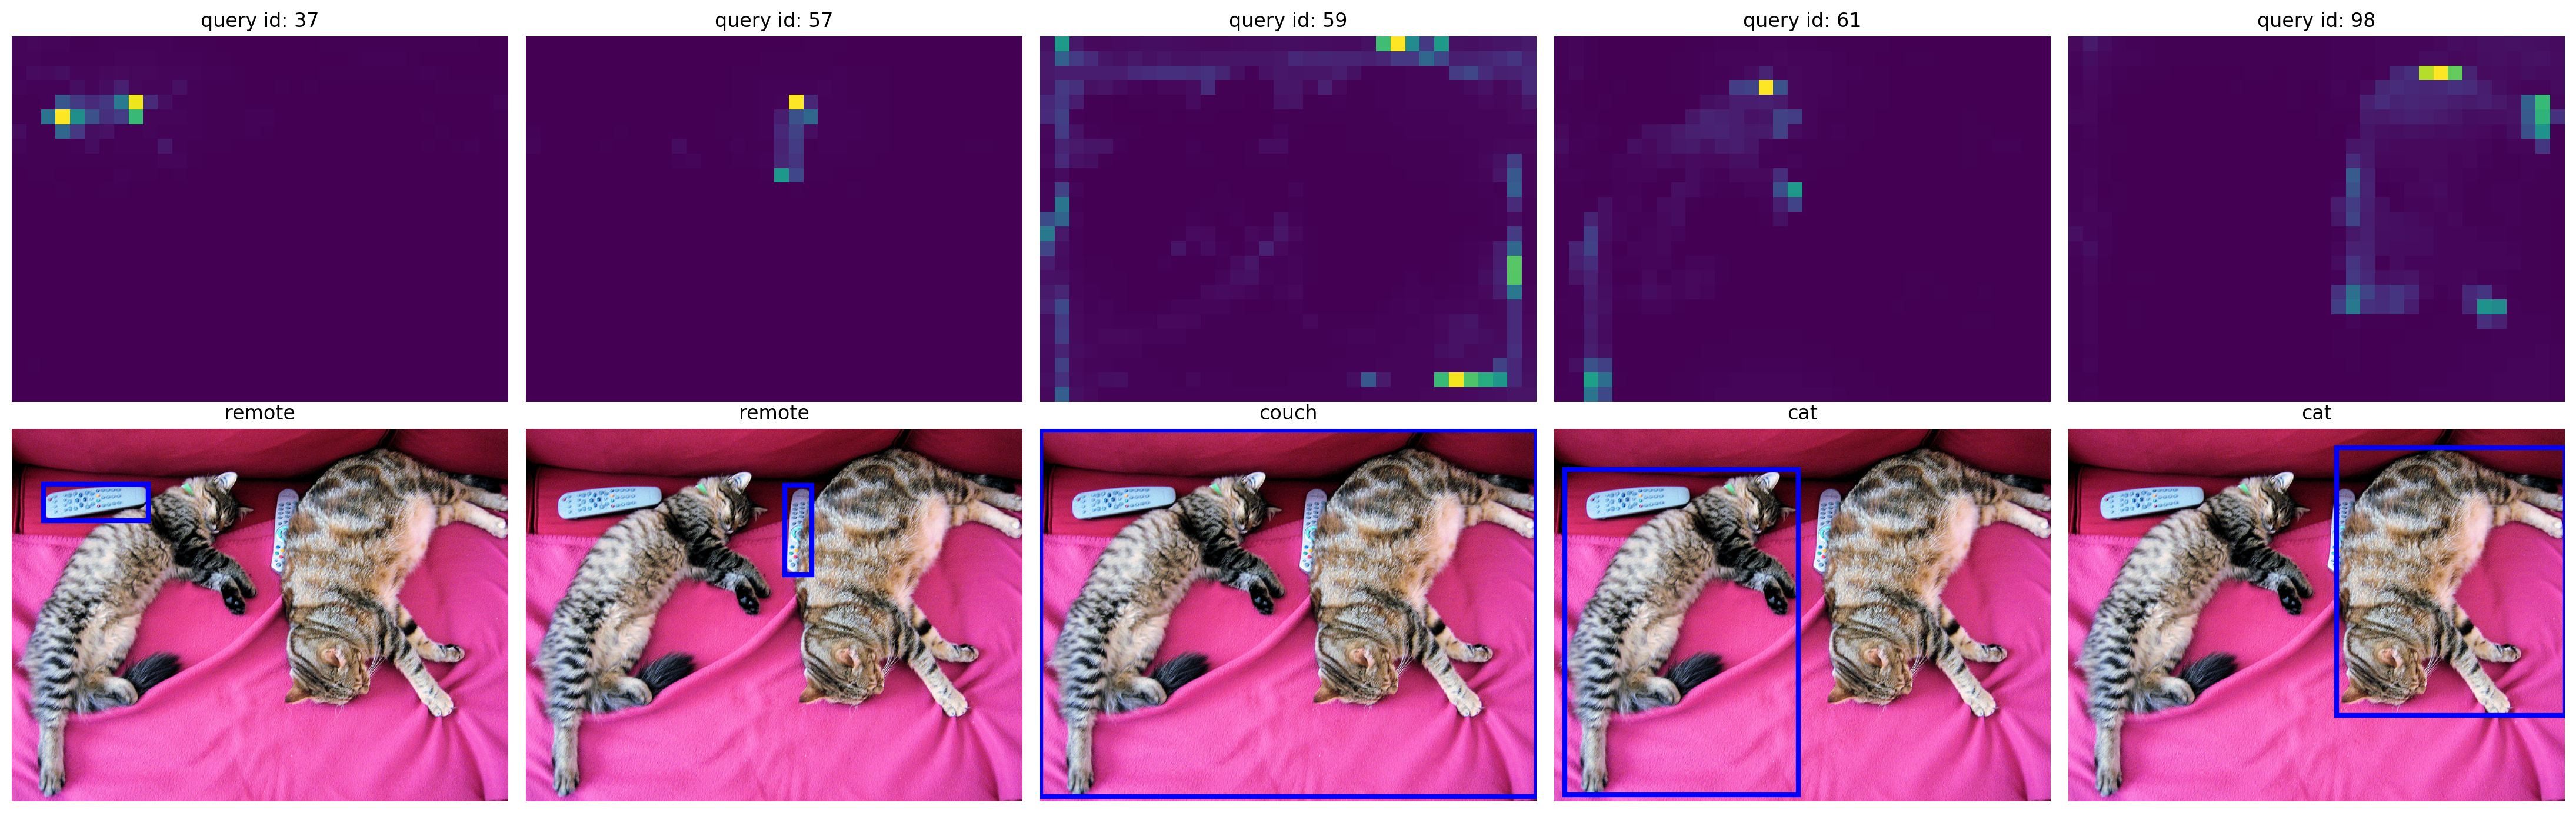

In [15]:
# get the feature map shape
h, w = conv_features['0'].tensors.shape[-2:]

fig, axs = plt.subplots(ncols=len(bboxes_scaled), nrows=2, figsize=(22, 7))
colors = COLORS * 100
for idx, ax_i, (xmin, ymin, xmax, ymax) in zip(keep.nonzero(), axs.T, bboxes_scaled):
    ax = ax_i[0]
    ax.imshow(dec_attn_weights[0, idx].view(h, w))
    ax.axis('off')
    ax.set_title(f'query id: {idx.item()}')
    ax = ax_i[1]
    ax.imshow(im)
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                               fill=False, color='blue', linewidth=3))
    ax.axis('off')
    ax.set_title(CLASSES[probas[idx].argmax()])
fig.tight_layout()

In [16]:
# output of the CNN
f_map = conv_features['0']
print("Encoder attention:      ", enc_attn_weights[0].shape)
print("Feature map:            ", f_map.tensors.shape)

Encoder attention:       torch.Size([850, 850])
Feature map:             torch.Size([1, 2048, 25, 34])


In [17]:
# get the HxW shape of the feature maps of the CNN
shape = f_map.tensors.shape[-2:]
# and reshape the self-attention to a more interpretable shape
sattn = enc_attn_weights[0].reshape(shape + shape)
print("Reshaped self-attention:", sattn.shape)

Reshaped self-attention: torch.Size([25, 34, 25, 34])


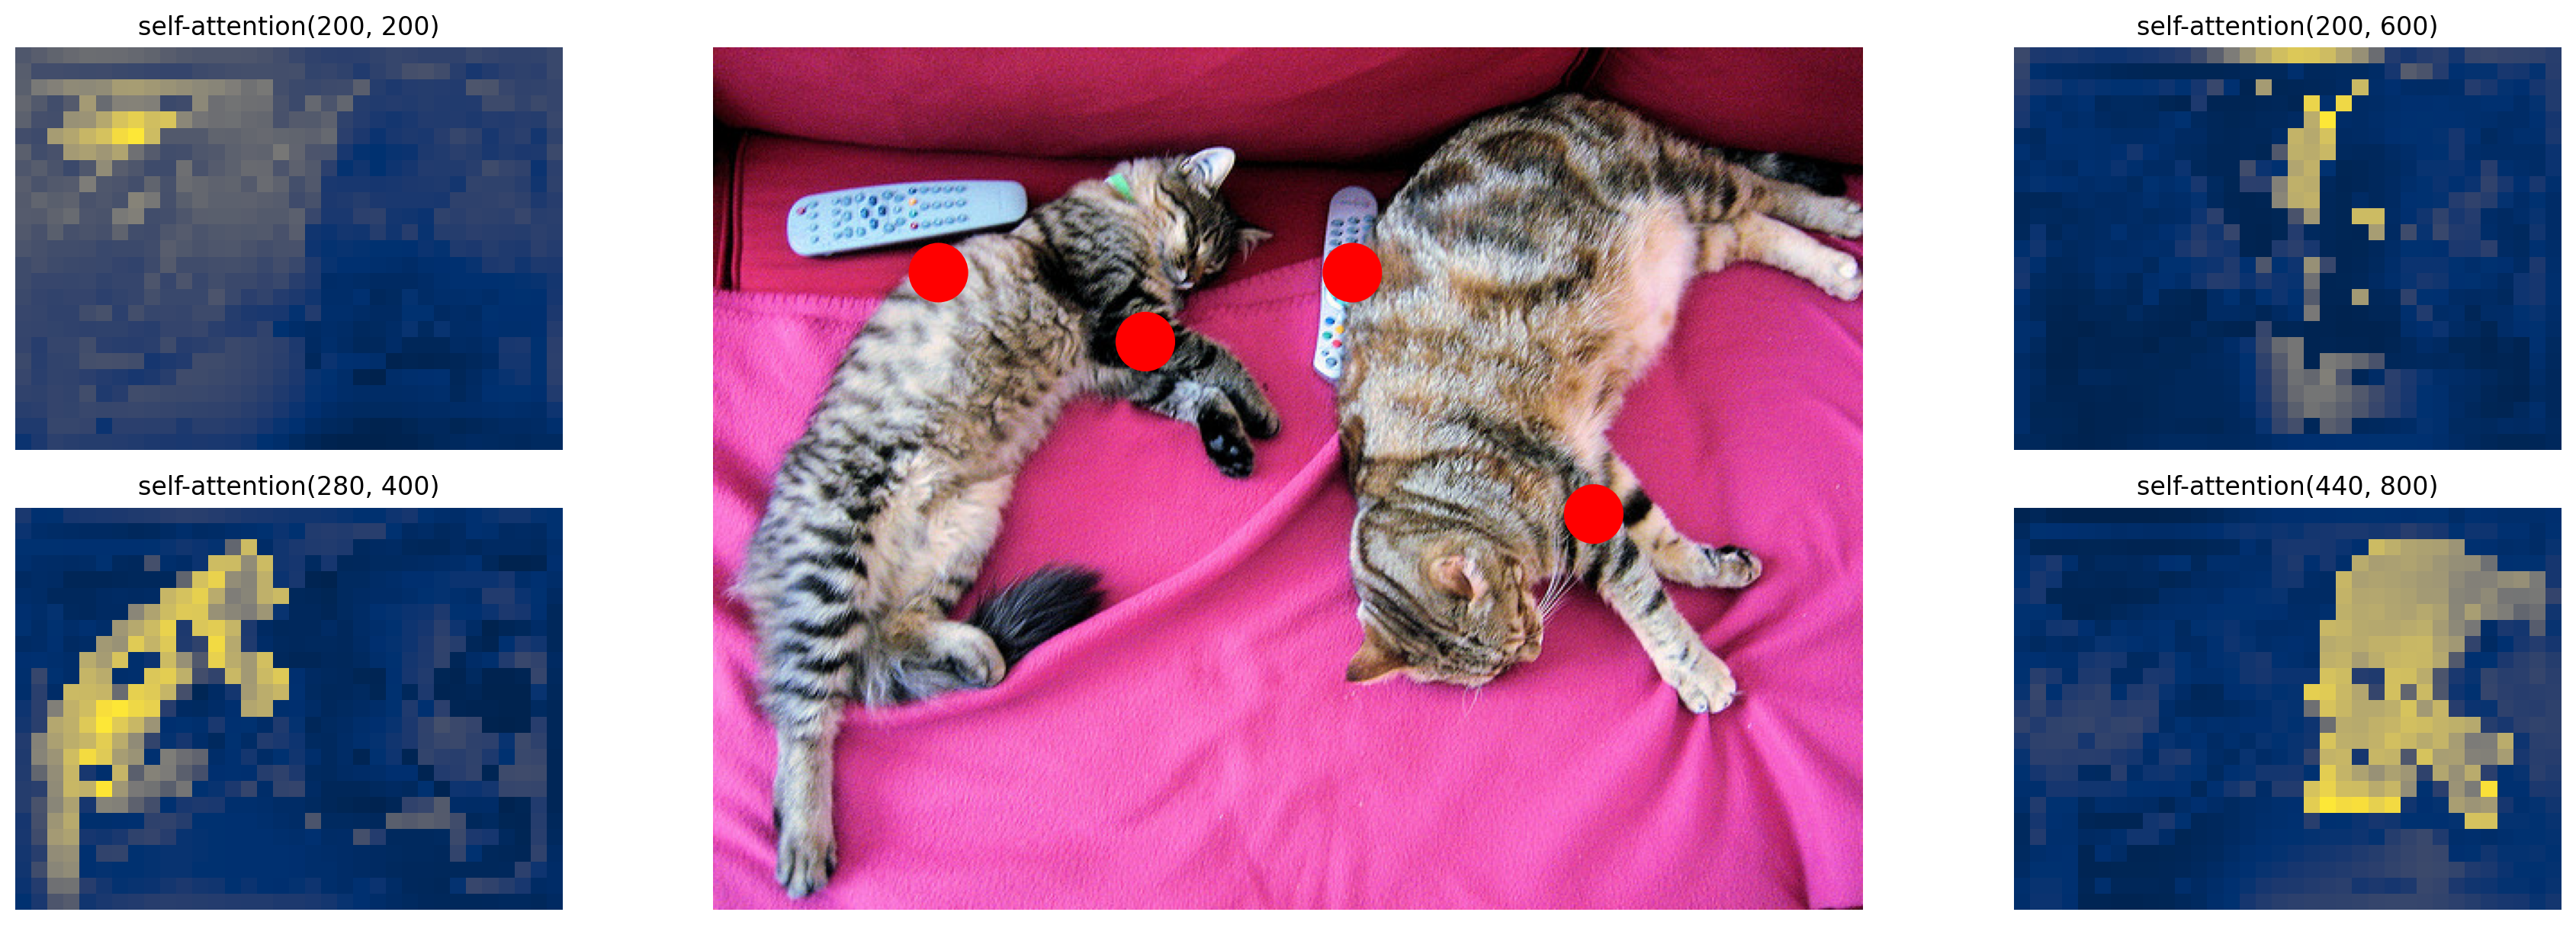

In [18]:
# downsampling factor for the CNN, is 32 for DETR and 16 for DETR DC5
fact = 32

# let's select 4 reference points for visualization
idxs = [(200, 200), (280, 400), (200, 600), (440, 800),]

# here we create the canvas
fig = plt.figure(constrained_layout=True, figsize=(25 * 0.7, 8.5 * 0.7))
# and we add one plot per reference point
gs = fig.add_gridspec(2, 4)
axs = [
    fig.add_subplot(gs[0, 0]),
    fig.add_subplot(gs[1, 0]),
    fig.add_subplot(gs[0, -1]),
    fig.add_subplot(gs[1, -1]),
]

# for each one of the reference points, let's plot the self-attention
# for that point
for idx_o, ax in zip(idxs, axs):
    idx = (idx_o[0] // fact, idx_o[1] // fact)
    ax.imshow(sattn[..., idx[0], idx[1]], cmap='cividis', interpolation='nearest')
    ax.axis('off')
    ax.set_title(f'self-attention{idx_o}')

# and now let's add the central image, with the reference points as red circles
fcenter_ax = fig.add_subplot(gs[:, 1:-1])
fcenter_ax.imshow(im)
for (y, x) in idxs:
    scale = im.height / img.shape[-2]
    x = ((x // fact) + 0.5) * fact
    y = ((y // fact) + 0.5) * fact
    fcenter_ax.add_patch(plt.Circle((x * scale, y * scale), fact // 2, color='r'))
    fcenter_ax.axis('off')

#### Takeaway messages

- Encoder의 Self-Attention은 이미지 전반에 걸쳐 분산된 주의를 집중하며, 장면 전체의 맥락을 파악하는 데 중점을 둔다.
- Decoder의 Cross-Attention은 객체 중심으로 국소화된 패턴을 보이며, 각 Object Query가 특정 객체를 정확히 탐지하도록 돕는다.
- 시각화 결과를 통해 DETR이 다양한 객체를 독립적으로 인식하고, 이를 기반으로 정확한 위치와 경계를 찾는 과정을 이해할 수 있다.


### **Q3. Understanding Attention Mechanisms**

In this task, you focus on understanding the attention mechanisms present in the encoder and decoder of DETR.

* Briefly describe the types of attention used in the encoder and decoder, and explain the key differences between them.

* Based on the visualized results from Q2, provide an analysis of the distinct characteristics of each attention mechanism in the encoder and decoder. Feel free to express your insights.

DETR(Detection Transformer)은 Object Detection을 위해 Transformer 구조를 도입한 모델로, Encoder와 Decoder에서 각각 다른 방식의 Attention Mechanism을 사용한다는 특징이 있다. 

#### Description about attentions

1. Encoder의 Self-Attention
Self-Attention은 Encoder에서 사용되는 Attention의 한 형태로, 각 입력 요소가 다른 입력 요소들과 상호작용하면서 자신을 포함한 모든 요소 간의 관계를 학습하는 방식이다. DETR의 Encoder는 전체 이미지의 픽셀(혹은 피처맵)을 입력으로 받아 이들 간의 상관관계를 학습하여, 이미지 전반에 걸쳐 유용한 정보를 추출한다. Self-Attention 메커니즘은 특정 영역에서 중요한 부분을 강조하고, 불필요한 영역은 덜 강조하여 모델이 전체 이미지를 효과적으로 이해할 수 있도록 돕는다.
Encoder의 Self-Attention은 전역적인 시야를 확보하며, 이미지 전체의 관계를 이해하고자 한다.
객체의 위치뿐만 아니라 배경 요소와의 관계를 함께 고려하기 때문에 전반적인 장면 이해에 적합하다.

2. Decoder의 Cross-Attention
Cross-Attention은 Decoder에서 사용되며, 주어진 Query와 Encoder의 출력 간의 상관관계를 학습하는 방식이다. DETR의 Decoder는 사전에 정의된 Object Queries를 통해 특정 객체와 관련된 특징적인 정보를 학습하며, 이를 통해 Encoder에서 학습된 전체 이미지의 정보에서 필요한 부분만을 집중적으로 분석한다. Cross-Attention 메커니즘은 Object Query가 각 객체의 위치와 경계를 찾을 수 있도록 도와준다.
Decoder의 Cross-Attention은 객체 중심적인 시야를 확보하며, 각 Object Query가 이미지의 특정 부분에 집중하도록 한다.
객체의 특징을 추출하고 특정 영역에 대한 세부 정보를 학습하는 데 특화되어 있어, Object Detection에 필요한 정보만을 효율적으로 사용한다.

#### Analysis of the distinct characteristics of each attention mechanism

Encoder의 Attention: 이미지 전반에 걸쳐 분산된 주의 집중이 관찰되며, 특히 객체뿐만 아니라 배경까지 함께 포함된 광범위한 패턴을 보인다. 이는 Encoder가 단순히 객체만이 아닌, 장면 전체를 이해하는 데 중점을 둔다는 점을 보여준다. 예를 들어, 자동차나 사람과 같은 주요 객체 주변뿐 아니라 도로와 하늘과 같은 배경 요소에도 주목하여 전체 맥락을 파악한다.

Decoder의 Attention: 각 Object Query가 특정한 객체에 집중하여, 선명하게 국소화된 패턴을 형성한다. 이는 모델이 여러 객체를 독립적으로 인식하고, 각 객체에 대한 정보만을 집중적으로 수집하는 것을 나타낸다. 예를 들어, 사람이나 동물과 같은 객체 주변에 강한 Attention이 집중되며, 이를 통해 모델이 객체의 경계와 특징을 명확하게 구분하는 것을 볼 수 있다.

즉, DETR의 Encoder와 Decoder의 Attention Mechanism은 전반적인 장면 이해와 객체 중심적인 정보 추출이라는 두 가지 상반된 목적을 효과적으로 수행하고 있다. Encoder의 Self-Attention은 전체 이미지의 포괄적 이해를, Decoder의 Cross-Attention은 특정 객체의 세부 정보 추출을 통해 Object Detection에서 우수한 성능을 발휘한다. 이처럼 두 Attention Mechanism이 상호 보완적으로 작용하며, DETR 모델이 고도의 Object Detection 작업을 수행할 수 있도록 한다.